# Bitcoin Market Predictor

Predicting BTCUSD market with a recurrent neural network

# Currency Market Predictor - Deep Regressor

Predicting BTCUSD market

In [34]:
import tensorflow as tf
from tensorflow.contrib import rnn
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Read data

In [328]:
dataset = pd.read_csv('data/coinbaseUSD_1-min_data_2014-12-01_to_2017-10-20.csv')
dataset.head(10)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1,1417412040,300.0,300.0,300.0,300.0,0.01,3.0,300.0
2,1417412100,300.0,300.0,300.0,300.0,0.01,3.0,300.0
3,1417412160,300.0,300.0,300.0,300.0,0.01,3.0,300.0
4,1417412220,300.0,300.0,300.0,300.0,0.01,3.0,300.0
5,1417412280,300.0,300.0,300.0,300.0,0.01,3.0,300.0
6,1417412340,300.0,300.0,300.0,300.0,0.01,3.0,300.0
7,1417412400,300.0,300.0,300.0,300.0,0.01,3.0,300.0
8,1417412460,300.0,300.0,300.0,300.0,0.01,3.0,300.0
9,1417412520,300.0,300.0,300.0,300.0,0.01,3.0,300.0


In [329]:
dataset.tail(10)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
1459066,1508457060,5705.25,5705.25,5705.24,5705.25,2.645729,15094.527857,5705.243162
1459067,1508457120,5705.01,5705.01,5705.01,5705.01,2.239995,12779.191992,5705.010000
1459068,1508457180,5705.01,5705.01,5701.01,5701.01,1.906660,10877.267534,5704.881021
1459069,1508457240,5703.22,5703.22,5700.00,5700.00,4.793786,27325.020313,5700.091678
1459070,1508457300,5700.01,5700.01,5700.00,5700.00,1.492222,8505.677349,5700.009268
1459071,1508457360,5700.01,5700.01,5700.00,5700.01,4.107598,23413.350886,5700.009878
1459072,1508457420,5700.01,5700.54,5700.01,5700.54,3.377075,19250.702466,5700.407366
1459073,1508457480,5700.54,5704.01,5700.53,5704.01,5.572255,31770.431877,5701.539951
1459074,1508457540,5703.96,5704.01,5702.87,5704.01,2.489754,14200.042922,5703.392752
1459075,1508457600,5704.00,5704.01,5704.00,5704.01,1.700455,9699.411610,5704.009412


In [330]:
# Make the neural net happy with the inputs: zero mean, -1 to 1
# only about 0.1% of high jumps in volume are clipped.

dataset['Weighted_Price_PCT'] = dataset['Weighted_Price'].pct_change(periods=10).fillna(0)
dataset['Weighted_Price_PCT'] = dataset['Weighted_Price_PCT']*2
dataset['Weighted_Price_PCT'] = dataset['Weighted_Price_PCT'].clip(-1,1)

dataset['Weighted_Price_PCT_100'] = dataset['Weighted_Price'].pct_change(periods=100).fillna(0)
dataset['Weighted_Price_PCT_100'] = dataset['Weighted_Price_PCT_100']*2
dataset['Weighted_Price_PCT_100'] = dataset['Weighted_Price_PCT_100'].clip(-1,1)

dataset['Weighted_Price_rolling_10'] = dataset['Weighted_Price_PCT'].rolling(10, win_type='triang').sum().clip(-1,1)

dataset['Weighted_Price_rolling_30'] = dataset['Weighted_Price_PCT'].rolling(100, win_type='triang').sum()
dataset['Weighted_Price_rolling_30'] = dataset['Weighted_Price_rolling_30']/3
dataset['Weighted_Price_rolling_30'] = dataset['Weighted_Price_rolling_30'].clip(-1,1)

dataset['Weighted_Price_rolling_90'] = dataset['Weighted_Price_PCT'].rolling(100, win_type='triang').sum()
dataset['Weighted_Price_rolling_90'] = dataset['Weighted_Price_rolling_90']/9
dataset['Weighted_Price_rolling_90'] = dataset['Weighted_Price_rolling_90'].clip(-1,1)

dataset['Weighted_Price_rolling_270'] = dataset['Weighted_Price_PCT'].rolling(100, win_type='triang').sum()
dataset['Weighted_Price_rolling_270'] = dataset['Weighted_Price_rolling_270']/27
dataset['Weighted_Price_rolling_270'] = dataset['Weighted_Price_rolling_270'].clip(-1,1)

dataset['Weighted_Price_rolling_100'] = dataset['Weighted_Price_PCT'].rolling(100, win_type='triang').sum()
dataset['Weighted_Price_PCT_100'] = dataset['Weighted_Price_PCT_100']/10
dataset['Weighted_Price_PCT_100'] = dataset['Weighted_Price_PCT_100'].clip(-1,1)


dataset['Volume_(BTC)_PCT'] = dataset['Volume_(BTC)'].pct_change(periods=10).fillna(0)
dataset['Volume_(BTC)_PCT'] = dataset['Volume_(BTC)_PCT'] + 1
dataset['Volume_(BTC)_PCT'] = np.clip(np.log(dataset['Volume_(BTC)_PCT'])/10, -1,1)
        
dataset['Volume_(BTC)_rolling_10'] = dataset['Volume_(BTC)_PCT'].rolling(10, win_type='triang').sum().clip(-1,1)


In [290]:
dataset.tail(100)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Weighted_Price_PCT,Weighted_Price_PCT_hour,Volume_(BTC)_PCT,Weighted_Price_rolling_hour,Weighted_Price_PCT_100,Weighted_Price_rolling_100,Weighted_Price_rolling_10,Weighted_Price_rolling_30,Weighted_Price_rolling_90,Weighted_Price_rolling_270,Volume_(BTC)_rolling_10
1458976,1508451660,5703.65,5705.00,5703.65,5705.00,4.433868,25292.554559,5704.400011,-0.008582,0.004716,-0.026775,0.024520,4.716239e-05,0.030659,-0.041485,0.010220,0.003407,0.001136,0.212522
1458977,1508451720,5705.00,5709.95,5705.00,5709.95,4.485310,25607.134336,5709.110890,-0.005705,0.006371,0.067646,0.022328,6.371343e-05,0.030281,-0.044467,0.010094,0.003365,0.001122,0.233040
1458978,1508451780,5705.00,5709.95,5705.00,5709.95,4.485310,25607.134336,5709.110890,-0.005178,0.005517,-0.038124,0.021921,5.517190e-05,0.029924,-0.044806,0.009975,0.003325,0.001108,0.243755
1458979,1508451840,5705.00,5709.95,5705.00,5709.95,4.485310,25607.134336,5709.110890,-0.003806,0.005308,0.112695,0.022787,5.308360e-05,0.029603,-0.042881,0.009868,0.003289,0.001096,0.208214
1458980,1508451900,5705.00,5709.95,5705.00,5709.95,4.485310,25607.134336,5709.110890,0.001369,0.005052,-0.164915,0.024216,5.052383e-05,0.029383,-0.038737,0.009794,0.003265,0.001088,0.138084
1458981,1508451960,5705.00,5709.95,5705.00,5709.95,4.485310,25607.134336,5709.110890,0.003048,0.003292,-0.064428,0.025346,3.292457e-05,0.029342,-0.032492,0.009781,0.003260,0.001087,0.087243
1458982,1508452020,5705.00,5709.95,5705.00,5709.95,4.485310,25607.134336,5709.110890,0.002986,0.002053,0.032066,0.025440,2.053229e-05,0.029490,-0.024844,0.009830,0.003277,0.001092,0.032239
1458983,1508452080,5705.00,5709.95,5705.00,5709.95,4.485310,25607.134336,5709.110890,0.001949,-0.002781,0.013869,0.023863,-2.780536e-05,0.029841,-0.016473,0.009947,0.003316,0.001105,-0.025980
1458984,1508452140,5705.00,5709.95,5705.00,5709.95,4.485310,25607.134336,5709.110890,0.001920,-0.003628,0.057291,0.020367,-3.628354e-05,0.030429,-0.007760,0.010143,0.003381,0.001127,-0.071674
1458985,1508452200,5705.00,5709.95,5705.00,5709.95,4.485310,25607.134336,5709.110890,0.001915,-0.003629,0.082074,0.014963,-3.629383e-05,0.031223,-0.000015,0.010408,0.003469,0.001156,-0.074192


In [246]:
dataset.tail(100)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Weighted_Price_PCT,Weighted_Price_PCT_hour,Volume_(BTC)_PCT,Weighted_Price_rolling_hour,Weighted_Price_PCT_100,Weighted_Price_rolling_100,Weighted_Price_rolling_10
1458976,1508451660,5703.65,5705.00,5703.65,5705.00,4.433868,25292.554559,5704.400011,-0.008582,0.004716,-0.026775,0.024520,0.000472,0.030659,-0.041485
1458977,1508451720,5705.00,5709.95,5705.00,5709.95,4.485310,25607.134336,5709.110890,-0.005705,0.006371,0.067646,0.022328,0.000637,0.030281,-0.044467
1458978,1508451780,5705.00,5709.95,5705.00,5709.95,4.485310,25607.134336,5709.110890,-0.005178,0.005517,-0.038124,0.021921,0.000552,0.029924,-0.044806
1458979,1508451840,5705.00,5709.95,5705.00,5709.95,4.485310,25607.134336,5709.110890,-0.003806,0.005308,0.112695,0.022787,0.000531,0.029603,-0.042881
1458980,1508451900,5705.00,5709.95,5705.00,5709.95,4.485310,25607.134336,5709.110890,0.001369,0.005052,-0.164915,0.024216,0.000505,0.029383,-0.038737
1458981,1508451960,5705.00,5709.95,5705.00,5709.95,4.485310,25607.134336,5709.110890,0.003048,0.003292,-0.064428,0.025346,0.000329,0.029342,-0.032492
1458982,1508452020,5705.00,5709.95,5705.00,5709.95,4.485310,25607.134336,5709.110890,0.002986,0.002053,0.032066,0.025440,0.000205,0.029490,-0.024844
1458983,1508452080,5705.00,5709.95,5705.00,5709.95,4.485310,25607.134336,5709.110890,0.001949,-0.002781,0.013869,0.023863,-0.000278,0.029841,-0.016473
1458984,1508452140,5705.00,5709.95,5705.00,5709.95,4.485310,25607.134336,5709.110890,0.001920,-0.003628,0.057291,0.020367,-0.000363,0.030429,-0.007760
1458985,1508452200,5705.00,5709.95,5705.00,5709.95,4.485310,25607.134336,5709.110890,0.001915,-0.003629,0.082074,0.014963,-0.000363,0.031223,-0.000015


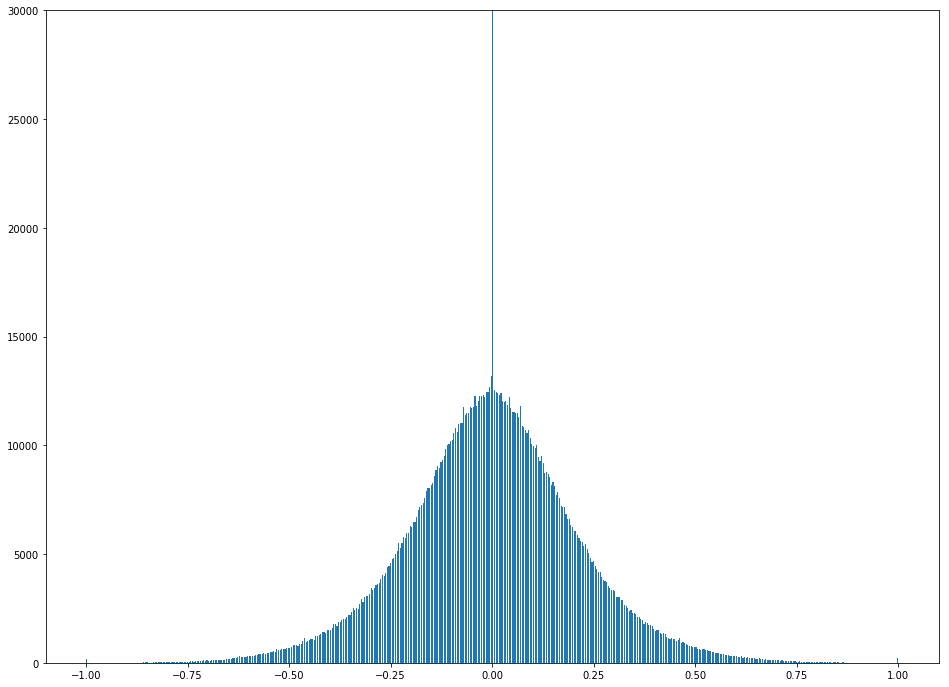

In [247]:
# Make sure the BTC Volume has nice NN properties

plt.figure(figsize=(16,12))

hist, bins = np.histogram(dataset['Volume_(BTC)_PCT'], bins=500)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
#plt.xlim(0, 10)
plt.ylim(0, 30000)
plt.show()

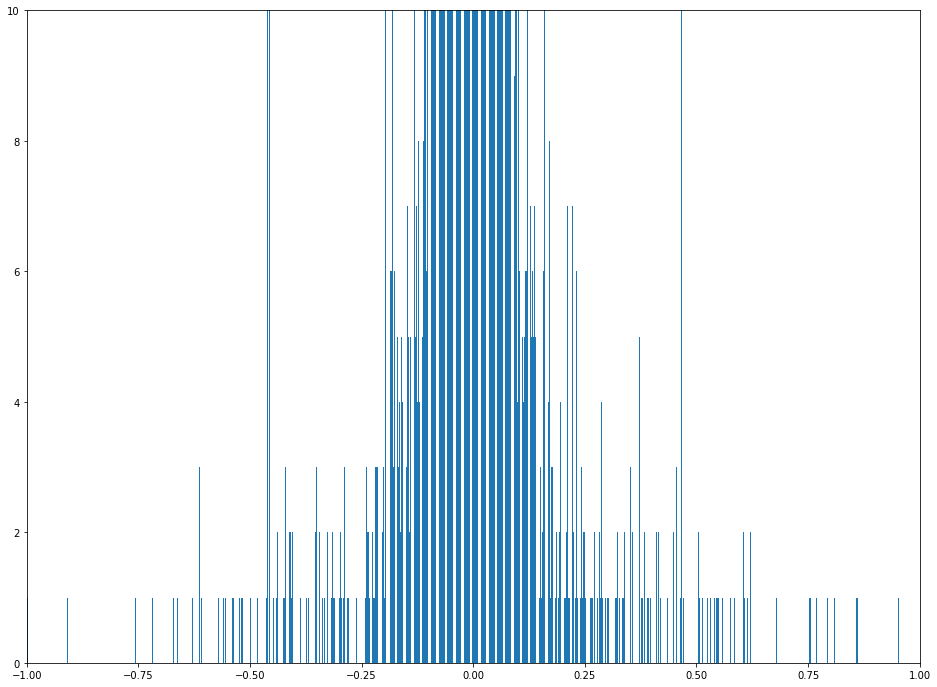

In [248]:

plt.figure(figsize=(16,12))


hist, bins = np.histogram(dataset['Weighted_Price_PCT'], bins=1000)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.xlim(-1, 1)
plt.ylim(0, 10)
plt.show()

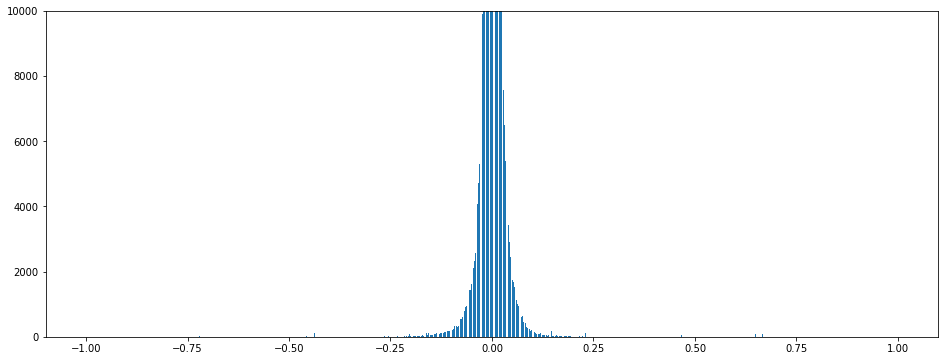

In [249]:
plt.figure(figsize=(16,6))
hist, bins = np.histogram(dataset['Weighted_Price_PCT_hour'], bins=1000)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
#plt.xlim(-1, 1)
plt.ylim(0, 10000)
plt.show()

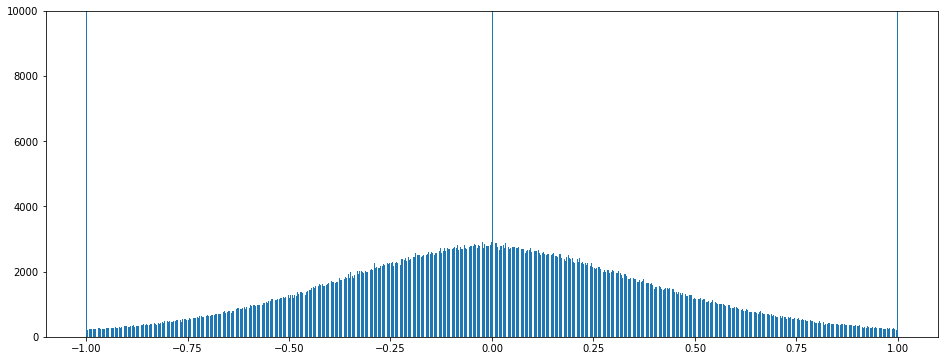

In [296]:
plt.figure(figsize=(16,6))
hist, bins = np.histogram(dataset['Volume_(BTC)_rolling_10'].iloc[1000:], bins=1000)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
#plt.xlim(-1, 1)
plt.ylim(0, 10000)
plt.show()

In [331]:
input_data = dataset[['Weighted_Price_rolling_10', 'Weighted_Price_rolling_30', 'Weighted_Price_rolling_90', 'Weighted_Price_rolling_270', 'Volume_(BTC)_rolling_10']].iloc[-1000000:] # about 2 years of data
target_data = dataset['Weighted_Price_PCT_100'].iloc[-1000000:]

# split data into test and validation data
prediction_mins = 18000 # 5 days 
training_input = input_data[:len(input_data)-prediction_mins]
validation_input = input_data[len(input_data)-prediction_mins:]

training_target = target_data[:len(target_data)-prediction_mins]
validation_target = target_data[len(target_data)-prediction_mins:]

In [347]:

X_train = training_input[0:-20]
Y_train = training_target[20:]

X_train = np.expand_dims(X_train, axis=1)

In [348]:
print(X_train.shape)
print(Y_train.shape)

(981980, 1, 5)
(981980,)


In [366]:
# Importing the Keras libraries and packages
from keras.models import Sequential, load_model
from keras.layers import LSTM, GRU, Dropout, Dense, GRUCell
from keras.callbacks import ModelCheckpoint, EarlyStopping

from numpy.testing import assert_allclose

In [361]:



early_stopping = EarlyStopping(monitor='val_loss', patience=2)

# Initialising the RNN
regressor = Sequential()

# Adding the input layer and the LSTM layer
regressor.add(GRU(512, return_sequences=True, input_shape = (None, 5)))

# Adding the input layer and the LSTM layer
regressor.add(GRU(units = 16, input_shape = (None, 256)))

# Adding the output layer
regressor.add(Dense(16, activation='tanh'))

# Adding the output layer
regressor.add(Dense(1, activation='linear'))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# define the checkpoint
filepath = "regressor.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]


In [370]:

# Fitting the RNN to the Training set
regressor.fit(X_train, Y_train, batch_size = 512, epochs = 100, validation_split=0.2, callbacks=[checkpoint])

Train on 785584 samples, validate on 196396 samples
Epoch 1/100
785584/785584 [==============================] - 16s 21us/step - loss: 9.6771e-07 - val_loss: 2.8798e-06
Epoch 2/100
785584/785584 [==============================] - 16s 21us/step - loss: 9.5558e-07 - val_loss: 2.8489e-06
Epoch 3/100
785584/785584 [==============================] - 17s 21us/step - loss: 9.4886e-07 - val_loss: 2.9319e-06
Epoch 4/100
785584/785584 [==============================] - 17s 21us/step - loss: 9.4830e-07 - val_loss: 2.8583e-06
Epoch 5/100
785584/785584 [==============================] - 16s 21us/step - loss: 9.4198e-07 - val_loss: 2.9349e-06
Epoch 6/100
785584/785584 [==============================] - 17s 21us/step - loss: 9.3434e-07 - val_loss: 2.8580e-06
Epoch 7/100
785584/785584 [==============================] - 17s 21us/step - loss: 9.3452e-07 - val_loss: 2.8418e-06
Epoch 8/100
785584/785584 [==============================] - 17s 21us/step - loss: 9.3200e-07 - val_loss: 2.8425e-06
Epoch 9/100


Epoch 33/100
785584/785584 [==============================] - 16s 21us/step - loss: 9.1592e-07 - val_loss: 2.8422e-06
Epoch 34/100
785584/785584 [==============================] - 16s 21us/step - loss: 9.1720e-07 - val_loss: 2.8404e-06
Epoch 35/100
785584/785584 [==============================] - 17s 21us/step - loss: 9.1624e-07 - val_loss: 2.8683e-06
Epoch 36/100
785584/785584 [==============================] - 17s 21us/step - loss: 9.1642e-07 - val_loss: 2.8409e-06
Epoch 37/100
785584/785584 [==============================] - 17s 21us/step - loss: 9.1594e-07 - val_loss: 2.8450e-06
Epoch 38/100
785584/785584 [==============================] - 17s 21us/step - loss: 9.1839e-07 - val_loss: 2.8658e-06
Epoch 39/100
785584/785584 [==============================] - 17s 21us/step - loss: 9.1577e-07 - val_loss: 2.8734e-06
Epoch 40/100
785584/785584 [==============================] - 17s 21us/step - loss: 9.1756e-07 - val_loss: 2.9590e-06
Epoch 41/100
785584/785584 [============================

Epoch 68/100
785584/785584 [==============================] - 16s 21us/step - loss: 9.1750e-07 - val_loss: 2.8424e-06
Epoch 69/100
785584/785584 [==============================] - 16s 21us/step - loss: 9.1473e-07 - val_loss: 2.8420e-06
Epoch 70/100
785584/785584 [==============================] - 16s 21us/step - loss: 9.1707e-07 - val_loss: 2.9020e-06
Epoch 71/100
785584/785584 [==============================] - 16s 21us/step - loss: 9.1696e-07 - val_loss: 2.8412e-06
Epoch 72/100
785584/785584 [==============================] - 16s 21us/step - loss: 9.1519e-07 - val_loss: 2.8418e-06
Epoch 73/100
785584/785584 [==============================] - 16s 21us/step - loss: 9.1628e-07 - val_loss: 2.8566e-06
Epoch 74/100
785584/785584 [==============================] - 16s 21us/step - loss: 9.1596e-07 - val_loss: 2.8338e-06
Epoch 75/100
785584/785584 [==============================] - 16s 21us/step - loss: 9.1624e-07 - val_loss: 2.8772e-06
Epoch 76/100
785584/785584 [============================

In [369]:
# load the model
new_model = load_model("regressor.h5")
assert_allclose(regressor.predict(X_train),
                new_model.predict(X_train), 1e-5)

KeyboardInterrupt: 

In [ ]:
# fit the model
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
new_model.fit(X_train, Y_train, epochs=5, batch_size=50, callbacks=callbacks_[checkpoint])

In [352]:
# Making the predictions

X_test = validation_input[0:-20]
Y_test = validation_target[20:]

X_test = np.expand_dims(X_test, axis=1)


#test_set = validation_input[0:len(validation_input)-60]
#test_set = np.expand_dims(test_set, axis=1)
#inputs = np.reshape(test_set, (len(test_set), 1, 1))
predicted_BTC_price = regressor.predict(X_test)


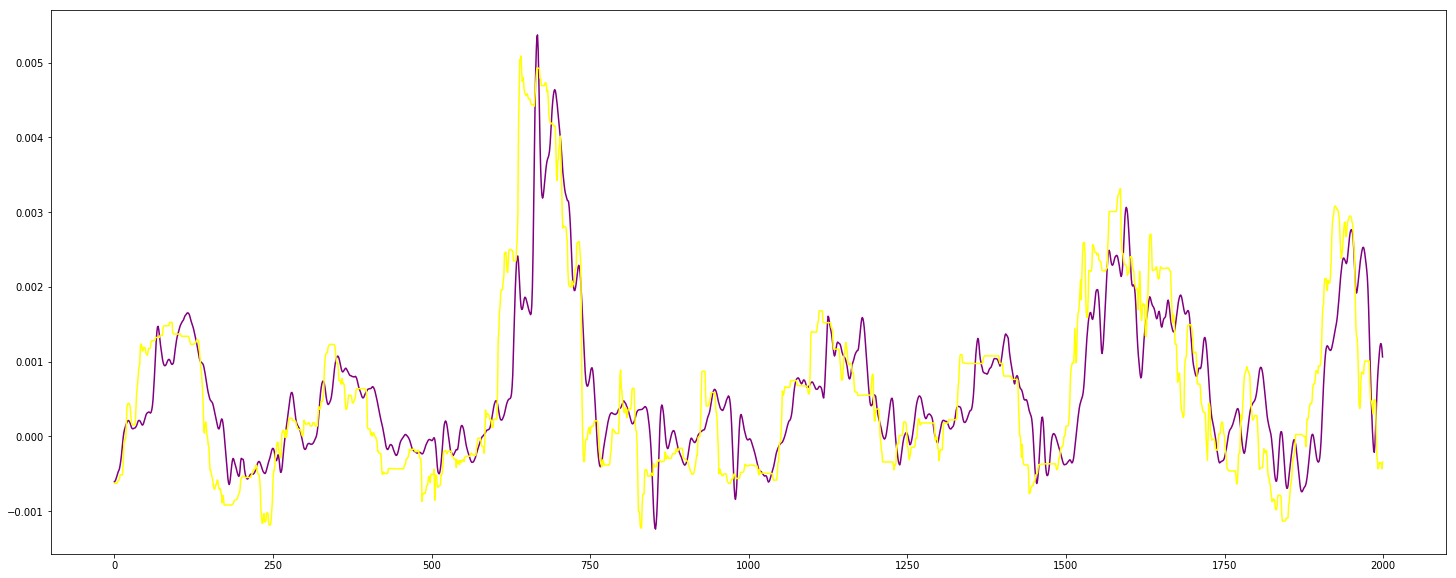

In [360]:
plt.figure(figsize=(25,10))
plt.plot(predicted_BTC_price[:2000], color = 'purple')
#plt.plot(X_test[270:800,0,:-1])
plt.plot(Y_test.values[:2000], color = 'yellow')

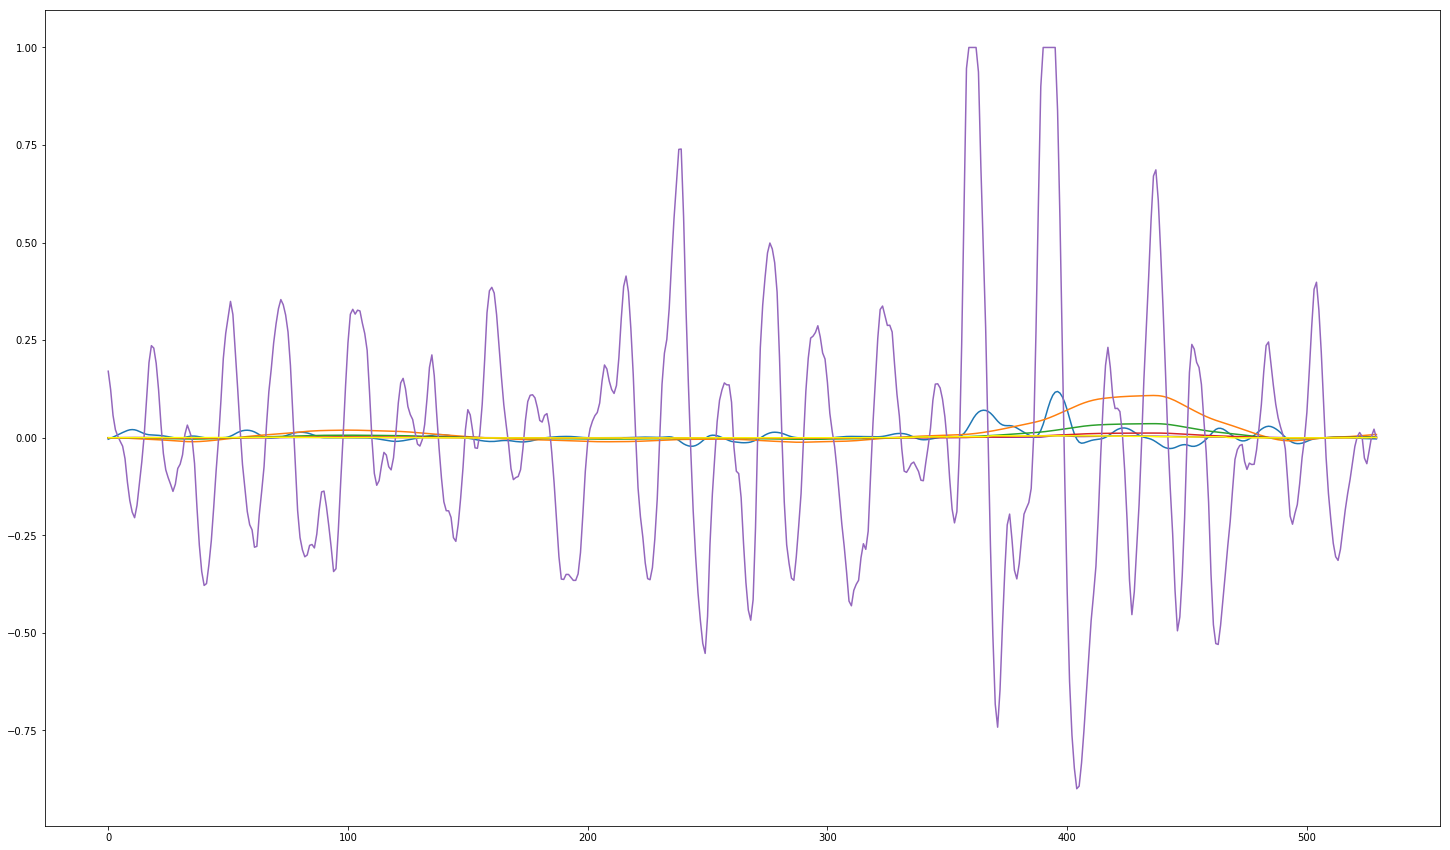

In [358]:
plt.figure(figsize=(25,15))
plt.plot(predicted_BTC_price[270:800], color = 'purple')
plt.plot(X_test[270:800,0,:])
plt.plot(Y_test.values[270:800], color = 'yellow')
#plt.ylim(0,0.05)

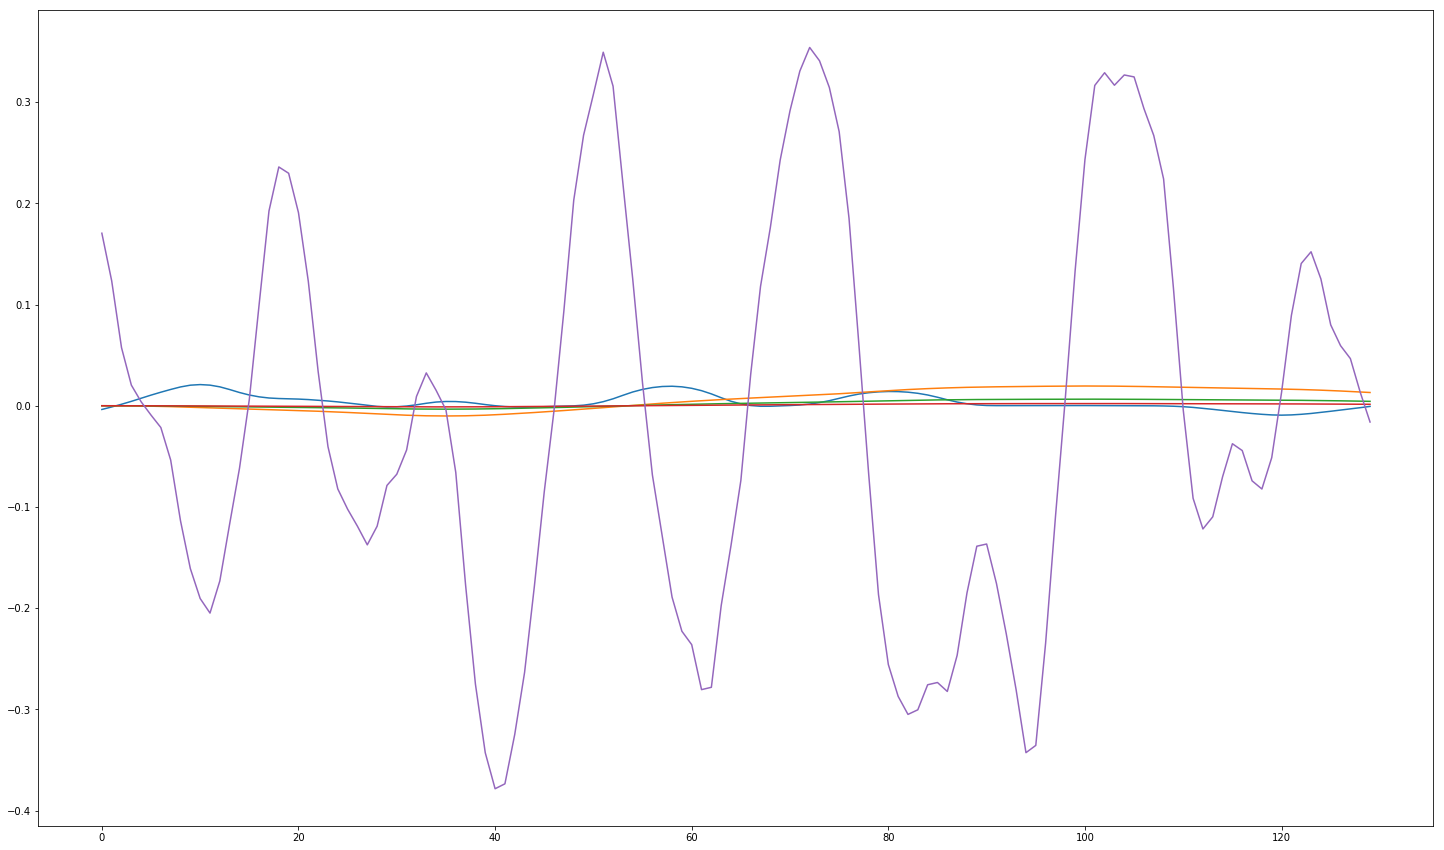

In [355]:
plt.figure(figsize=(25,15))
plt.plot(X_test[270:400,0,:])

In [356]:
plt.figure(figsize=(25,15))
plt.plot(dataset['Weighted_Price_PCT_hour'].iloc[-5000:])
plt.plot(dataset['Weighted_Price_PCT'].iloc[-5000:])
#plt.plot(dataset['Volume_(BTC)_PCT'].iloc[-5000:]*0.01)

KeyError: 'Weighted_Price_PCT_hour'